In [10]:
import rioxarray as rxr
import xarray as xr # handle netcdf files
import matplotlib.pyplot as plt #for plotting
import cartopy.crs as ccrs #for map projection
import cartopy.feature as cfeature #adding features to the map
import rasterio

In [ ]:
path = r"D:\OneDrive\Desktop\Landuse Modelling"
input_path = path + r"\data\copernicus_raster100m\DATA\U2018_CLC2018_V2020_20u1.tif"
output_path = path + r"output\file.txt"
df = rxr.open_rasterio(input_path)
df


<xarray.DataArray (band: 1, y: 46000, x: 65000)> Size: 3GB
[2990000000 values with dtype=int8]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 520kB 9e+05 9.002e+05 9.002e+05 ... 7.4e+06 7.4e+06
  * y            (y) float64 368kB 5.5e+06 5.5e+06 5.5e+06 ... 9.002e+05 9e+05
    spatial_ref  int64 8B 0
Attributes: (12/13)
    AREA_OR_POINT:           Area
    DataType:                Thematic
    RepresentationType:      THEMATIC
    STATISTICS_COVARIANCES:  136.429646247598
    STATISTICS_MAXIMUM:      48
    STATISTICS_MEAN:         25.753373398066
    ...                      ...
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       11.680310194836
    _FillValue:              -128
    scale_factor:            1.0
    add_offset:              0.0

d:\OneDrive\Desktop\Landuse Modelling\.venv\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
d:\OneDrive\Desktop\Landuse Modelling\.venv\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
d:\OneDrive\Desktop\Landuse Modelling\.venv\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_rivers_lake_centerlines.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
d:\OneDrive\Desktop\Landuse Modelling\.venv\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_lakes.zip
  warnings.warn(f'Downloading: {url}

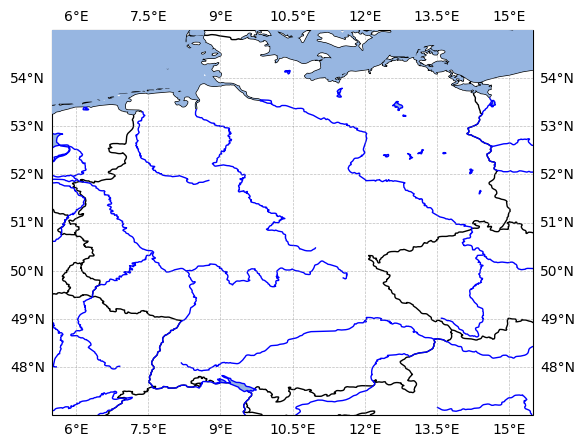

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(50, 5), subplot_kw={'projection': ccrs.PlateCarree()}) #add cartopy projection
#add coastlines
ax.add_feature(cfeature.COASTLINE)
#add borders
ax.add_feature(cfeature.BORDERS)


#to add gridlines
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
#set extent of the map
ax.set_extent([5.5, 15.5, 47, 55], crs=ccrs.PlateCarree())

In [17]:
import rasterio
from rasterio.windows import from_bounds
from rasterio.warp import transform_bounds
from rasterio.enums import Resampling

# Pfad zur Datei
min_x, max_x = 3900000, 4600000
min_y, max_y = 2800000, 3300000

scale = 0.1  # 10 % der Originalgröße

with rasterio.open(path) as src:
    window = from_bounds(min_x, min_y, max_x, max_y, transform=src.transform)

    # Berechne reduzierte Größe
    out_height = int(window.height * scale)
    out_width = int(window.width * scale)

    raster = src.read(
        1,
        window=window,
        out_shape=(out_height, out_width),
        resampling=Resampling.average
    )
    transform = src.window_transform(window)

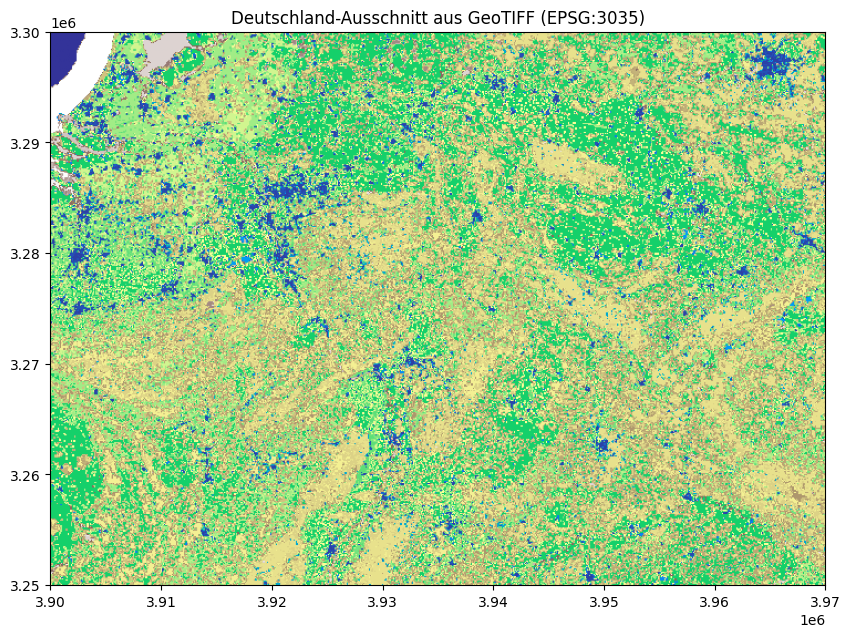

In [20]:
from rasterio.plot import show
fig, ax = plt.subplots(figsize=(10, 8))
show(raster, transform=transform, ax=ax, cmap='terrain')
ax.set_title("Deutschland-Ausschnitt aus GeoTIFF (EPSG:3035)")
plt.show()

In [40]:
da = rxr.open_rasterio(path).squeeze()  # 1. Band, 2D
da.rio.write_crs("EPSG:3035", inplace=True)
da_wgs84 = da.rio.reproject("EPSG:4326")
# Bounding Box für Deutschland in EPSG:3035 (Meter)
min_x, max_x = 5.5, 15.5
min_y, max_y = 47, 55

# Zuschneiden auf Deutschland
da_de = da_wgs84.rio.clip_box(minx=min_x, maxx=max_x, miny=min_y, maxy=max_y)

# OPTIONAL: Downsampling (z. B. um Faktor 10)
scale = 0.1
#da_small = da_de.coarsen(x=int(1/scale), y=int(1/scale), boundary="trim").mean()

# Reprojection nach WGS84


MemoryError: Unable to allocate 2.78 GiB for an array with shape (1, 46000, 65000) and data type int8

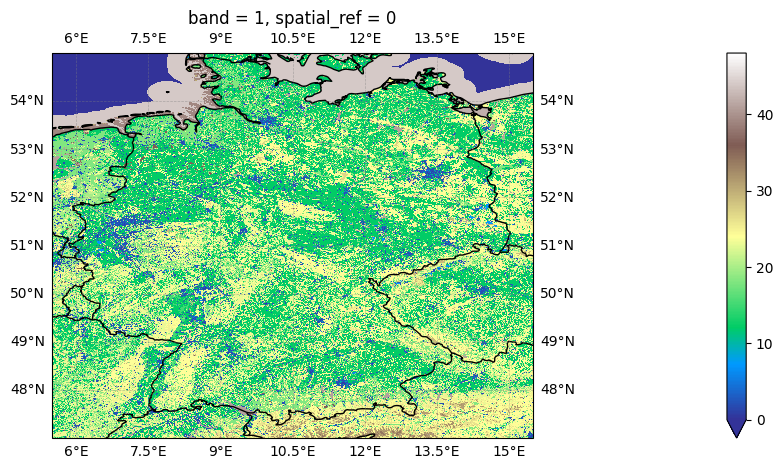

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(50, 5), subplot_kw={'projection': ccrs.PlateCarree()}) #add cartopy projection
#add coastlines
ax.add_feature(cfeature.COASTLINE)
#add borders
ax.add_feature(cfeature.BORDERS)


#to add gridlines
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
#set extent of the map
ax.set_extent([5.5, 15.5, 47, 55], crs=ccrs.PlateCarree())
da_de.plot(ax=ax, cmap='terrain', vmin=0, vmax=48)

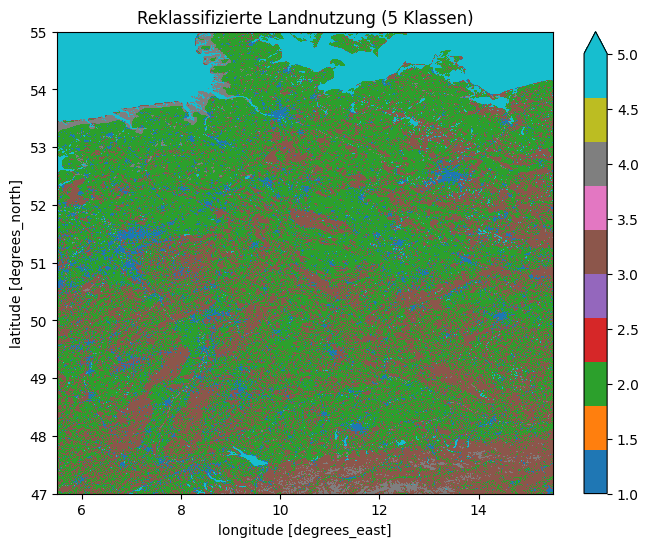

In [38]:
import numpy as np 
grouped = ((da_de - 1) // 10 + 1).astype(np.uint8)

fig, ax = plt.subplots(figsize=(8, 6))
grouped.plot(ax=ax, cmap='tab10', vmin=1, vmax=5)
ax.set_title("Reklassifizierte Landnutzung (5 Klassen)")
plt.show()

In [37]:
grouped

<xarray.DataArray (y: 6249, x: 7810)> Size: 49MB
array([[13, 13, 13, ...,  5,  5,  5],
       [13, 13, 13, ...,  5,  5,  5],
       [13, 13, 13, ...,  5,  5,  5],
       ...,
       [ 3,  3,  3, ...,  2,  2,  2],
       [ 3,  3,  3, ...,  2,  2,  2],
       [ 3,  3,  3, ...,  2,  2,  2]], shape=(6249, 7810), dtype=uint8)
Coordinates:
  * x            (x) float64 62kB 5.5 5.501 5.502 5.504 ... 15.5 15.5 15.5 15.5
  * y            (y) float64 50kB 55.0 55.0 55.0 55.0 ... 47.0 47.0 47.0 47.0
    band         int64 8B 1
    spatial_ref  int64 8B 0

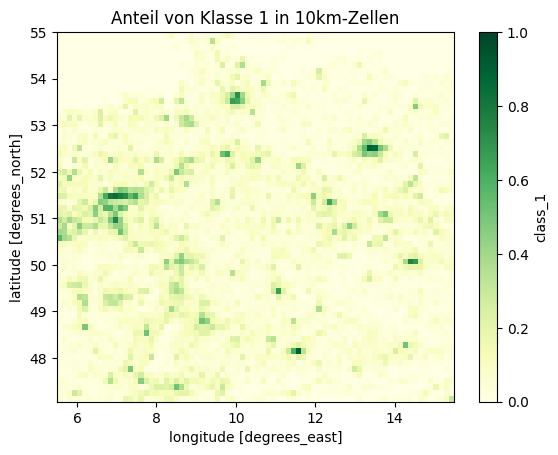

In [39]:
# === 1. Raster laden ===
classes = np.unique(grouped.values[~np.isnan(grouped.values)]).astype(int)  # z. B. [1, 2, ..., 48]

# === 2. Bereite leeren Container vor ===
layers = []

# 100m → 10km = Faktor 100
agg_factor = 100

for cls in classes:
    mask = (grouped == cls).astype(np.float32)

    # Mittelung über 100x100 Blöcke → Anteil pro Klasse
    aggregated = mask.coarsen(x=agg_factor, y=agg_factor, boundary="trim").mean()

    # Optional: Namen setzen
    aggregated.name = f"class_{cls}"
    layers.append(aggregated)

# === 3. Zu Dataset zusammenfügen ===
ds = xr.merge(layers)

# === 4. Plot Beispielklasse ===
import matplotlib.pyplot as plt
ds["class_1"].plot(cmap="YlGn", vmin=0, vmax=1)
plt.title("Anteil von Klasse 1 in 10km-Zellen")
plt.show()

In [41]:
path = r"D:\OneDrive\Desktop\Landuse Modelling\aggregated_landuse_classes.nc"
ds.to_netcdf(path)

In [47]:
data = xr.open_dataset(path).load()
data.class_5.max()

<xarray.DataArray 'class_5' ()> Size: 4B
array(1., dtype=float32)
Coordinates:
    band         int64 8B 1
    spatial_ref  int64 8B 0